# Used Cars Evaluation
### DESCRIPTION

The used car market has significantly grown in recent times, with clients ranging from used car dealers and buyers. You are provided with a car evaluation dataset that has features like price, doors, safety, and so on.

### Objective: 
You are required to create a robust model that allows stakeholders to predict the condition of a used vehicle.

### Actions to Perform:

    * Predict the condition of a vehicle based on its features.
    * Plot the most important features.
    * Train multiple classifiers and compare the accuracy.
    * Evaluate the XGBoost model with K-fold cross-validation.
    
### Car Evaluation Database
It is a multi-class classification problem. Task is to classify our dataset into 4 classes : Unacceptable, Acceptable, Good, Very-Good.

### Independent variables
    buying : buying price
    maint : maintenance price
    doors : number of doors
    persons : capacity in terms of persons to carry
    lug_boot : the size of luggage boot
    safety: estimated safety of the car
### Target Variable
Class

In [1]:
# importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import warnings
warnings.filterwarnings ('ignore')

In [2]:
# importing the data set

cars = pd.read_csv (r'H:\Documents\Study material\Data Science course\Machine Learning\Data sets\Lesson 9\car_evaluation.csv')
cars.head ()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [3]:
# checking the data information

cars.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


##### Inferences :
    1. There are 1728 records and 7 columns in the data.
    2. All columns are mentioned as object type of column and we would want to convert them to numerical type.
    3. There are no missing values in the data.
    4. Our target variable is class which we would want to explore further.

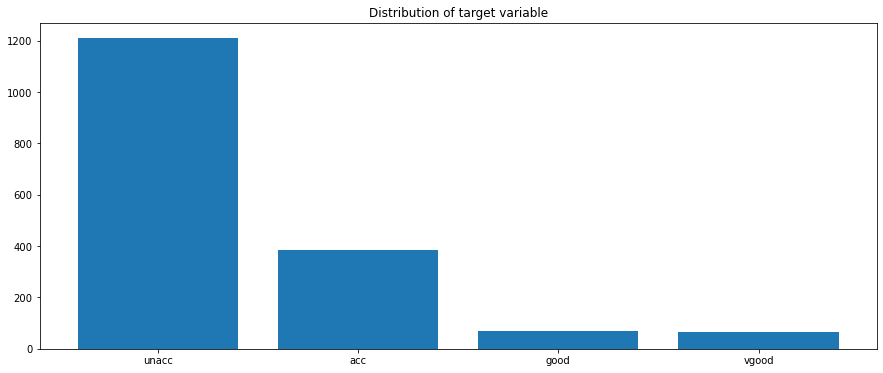

In [4]:
# Checking the distribution of our target variable

plt.figure (figsize = (15,6))
target = cars ['class'].value_counts ()
plt.bar (target.index, target.values)
plt.title ('Distribution of target variable');

##### It is clearly an imbalanced problem which we would want to deal with during further analysis.

In [5]:
# checking the number of unique values in the predictors

cars.nunique ()

buying      4
maint       4
doors       4
persons     3
lug_boot    3
safety      3
class       4
dtype: int64

##### We can plot the bar chart of each to understand each predictor.

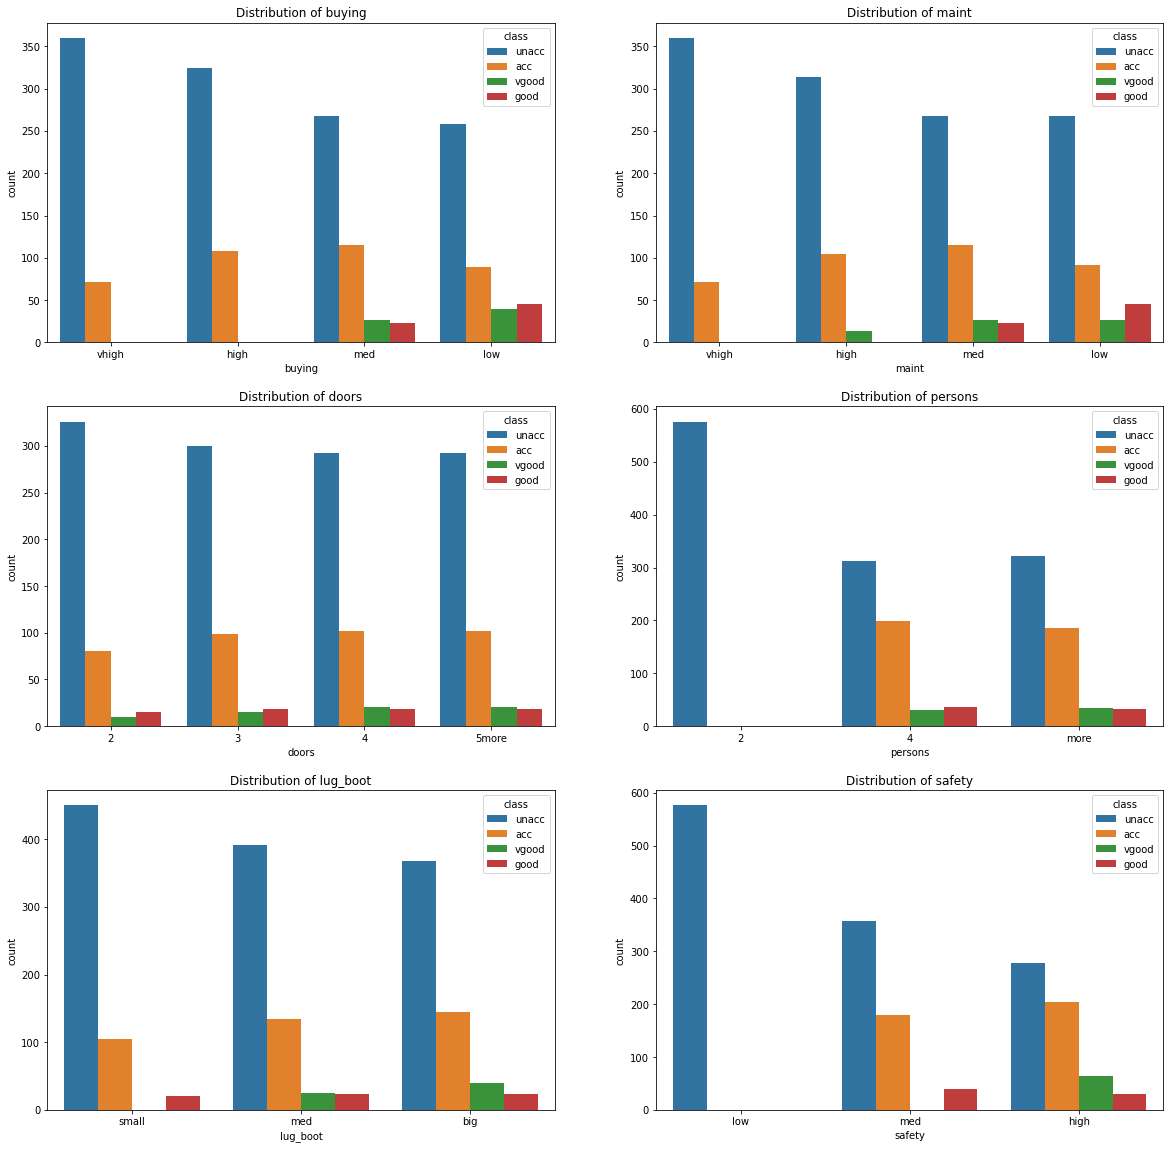

In [6]:
# checking the distributions of all the predictors

plt.figure (figsize = (20,20))
for i, col in enumerate (cars.columns [:-1]) :
    plt.subplot (3,2,i+1)
    sns.countplot (cars [col], hue = cars ['class'], dodge = True)
    plt.title (f'Distribution of {col}');

##### Inferences :
    1. There seems to be a clear relationship of the class with each variable.
    2. For buying price and maintenance cost the unacceptable class increases with the predictor and
       for all others, it decreases with predictors.
    3. The doors variable has a class 5 and more which can be replaced by 5.
    4. The person carrying capacity of the car has a class more. Assuming maximum number of people any car
       can carry is 7, we take a mean of 5, 6, 7 for imputation of more class.
    5. We can observe that all the variables are ordinal type and we convert them to numerical for accordingly.

In [7]:
# Defining the categories for the variables

cat1 = {'vhigh' : 4, 'high' : 3, 'med' : 2, 'low' : 1}
cat2 = {'small' : 1, 'med' : 2, 'big' : 3}
cat3 = {'low' : 1, 'med' : 2, 'high' : 3}
target_cat = {'unacc' : 1, 'acc' : 2, 'good' : 3, 'vgood' : 4}

In [8]:
# replacing the values in the buying and maint columns

for col in ['buying', 'maint'] :
    cars [col] = cars [col].replace (cat1)
    
# replacing the values in the lug_boot column

cars ['lug_boot'] = cars ['lug_boot'].replace (cat2)

# replacing the values in the lug_boot column

cars ['safety'] = cars ['safety'].replace (cat3)

# replacing the values in columns doors and persons

cars ['doors'] = cars ['doors'].replace ({'5more' : '5'}).astype ('int64')
cars ['persons'] = cars ['persons'].replace ({'more' : '6'}).astype ('int64')

# replacing the values in the target column

cars ['class'] = cars ['class'].replace (target_cat)

cars.head ()

,buying,maint,doors,persons,lug_boot,safety,class
0,4,4,2,2,1,1,1
1,4,4,2,2,1,2,1
2,4,4,2,2,1,3,1
3,4,4,2,2,2,1,1
4,4,4,2,2,2,2,1


##### Now that the columns are converted to numerical form, let's check the correlation coefficients.

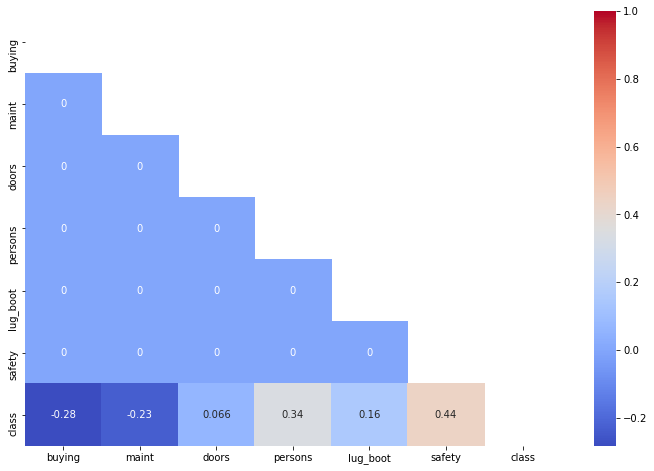

In [9]:
# Correlation matrix

plt.figure (figsize = (12,8))
cars_corr = cars.corr ()
m = np.triu (np.ones_like (cars_corr))
sns.heatmap (cars_corr, cmap = 'coolwarm', annot = True, mask = m);

##### Inferences :
    1. There is no correlation between the predictors.
    2. The correlation of each predictor with the target column is also low with safety having the 
       maximum correlation coefficient of 0.44 with the target and doors having the lowest amongst all.
    3. The reason for low correlations can also be due to columns being categorical.
    4. We can conduct the chi-squared test to check for the significant variables.

In [10]:
# Peforming the chi-squared test between each predictor and target

for col in cars.columns [:-1] :
    table = pd.crosstab (cars [col], cars ['class'])
    print ('For chi-squared test between {} and class, p-value = {:.4f}'.format (col, 
                                                                                 chi2_contingency (table) [1]))

For chi-squared test between buying and class, p-value = 0.0000
For chi-squared test between maint and class, p-value = 0.0000
For chi-squared test between doors and class, p-value = 0.3202
For chi-squared test between persons and class, p-value = 0.0000
For chi-squared test between lug_boot and class, p-value = 0.0000
For chi-squared test between safety and class, p-value = 0.0000


##### From the chi-squared test also we can observe that there is not enough evidence to believe that the doors has any relation with the class. Hence, we can remove it from predictions.

In [11]:
# Separating the features and response variables

X = cars.drop (columns = ['doors', 'class']).values
y = cars ['class'].values

In [12]:
# defining the weights for the imbalanced classes

weights = dict (cars.shape [0] / (cars ['class'].value_counts () * cars ['class'].nunique ()))
print ('class weights =', weights)

class weights = {1: 0.35702479338842974, 2: 1.125, 3: 6.260869565217392, 4: 6.6461538461538465}


In [20]:
# defining a function for building the model, hyperparameter tuning and presenting the results

def classification (clf, params, cv = 5, n_iter = 100) :
    
    # defining stratefied K-Fold
    
    skf = StratifiedKFold (n_splits = cv)
    
    # Using RandomizedSearchCV for hyperparameter tuning
    
    rand_cv = RandomizedSearchCV (estimator = clf, param_distributions = params, 
                                  cv = skf, scoring = 'f1_weighted', return_train_score = True,
                                  n_iter = n_iter, n_jobs = -1).fit (X, y)
    
    # displaying the best parameters and best score
    
    print ('The best parameters for {} = {}'.format (str (clf).partition ('(') [0], 
                                                     rand_cv.best_params_))
    
    print ('The best mean score = {:.4f}'.format (rand_cv.best_score_))
    
    # Making predictions
    
    # storing the cross validation results in the data frame
    
    cv_results = pd.DataFrame (rand_cv.cv_results_)
    
    # Plotting the cross validation results for the best estimator
    
    train_scores = cv_results.loc [rand_cv.best_index_, ['split{}_train_score'.format (i) for i in range (cv)]].values
    test_scores = cv_results.loc [rand_cv.best_index_, ['split{}_test_score'.format (i) for i in range (cv)]].values
    print ('Mean train score = {}, std = {}'.format (train_scores.mean (), train_scores.std ()))
    print ('Mean test score = {}, std = {}'.format (test_scores.mean (), test_scores.std ()))
    
    plt.figure (figsize = (15, 6))
    plt.ylim (0,1)
    plt.title ('Cross validation f1 score')
    
    # plotting train score
    plt.plot (range (cv), train_scores, color = 'b', label = 'train score')
    upperval_train = list (train_scores + train_scores.std())
    lowerval_train = list (train_scores - train_scores.std())
    plt.fill_between (range (cv), upperval_train, lowerval_train, color = 'b', alpha = 0.15)
    
    # Plotting test score
    plt.plot (range (cv), test_scores, color = 'r', label = 'test score')
    upperval_test = list (test_scores + test_scores.std())
    lowerval_test = list (test_scores - test_scores.std())
    plt.fill_between (range (cv), upperval_test, lowerval_test, color = 'r', alpha = 0.15)
    
    plt.legend ()
    plt.show ()
    
    return (rand_cv.best_estimator_)

### Logistic Regression model

The best parameters for LogisticRegression = {'solver': 'liblinear', 'penalty': 'l1', 'C': 1.438449888287663}
The best mean score = 0.7807
Mean train score = 0.8435322923266837, std = 0.012393591728411785
Mean test score = 0.7807082917672754, std = 0.09094529906556427


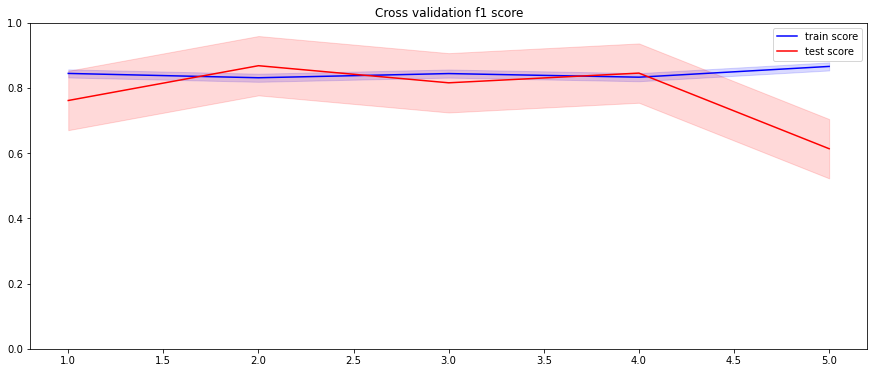

In [14]:
# Setting parameters for logistic regression model and finding the best results

params = {'solver' : ['newton-cg', 'lbfgs', 'liblinear'], 
          'penalty' : ['l1', 'l2', None], 
          'C' : np.logspace (-3, 2, 20)}

logmodel = LogisticRegression (class_weight = weights, max_iter = 500)

logmodel = classification (logmodel, params)

##### Inferences :
    1. The Logistic Regression model gave a mean f1 score of 0.78.
    2. There is a high variation in the test results of Logistic Regression.
    3. We can conclude that the model is not stable.

### Naive Bayes model

The best parameters for MultinomialNB = {'alpha': 1}
The best mean score = 0.5787
Mean train score = 0.5785415515572074, std = 0.0007164325122506732
Mean test score = 0.5786895509098346, std = 0.00405310004199919


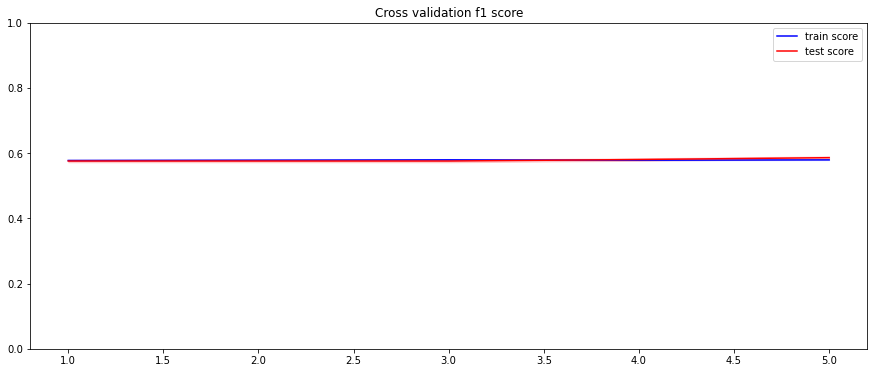

In [16]:
# Setting parameters for naive bayes model and finding the best results

params = {'alpha' : [1]}

nbmodel = MultinomialNB ()

nbmodel = classification (nbmodel, params)

##### Inferences :
    1. The Naive Bayes model gave a mean f1 score of 0.58 which is very low.
    2. There is not much variation in the test results though.
    3. Though the model is stable but the results are poor.

The best parameters for KNeighborsClassifier = {'weights': 'distance', 'p': 4, 'n_neighbors': 15}
The best mean score = 0.8462
Mean train score = 0.9665511832372478, std = 0.0017531163442570503
Mean test score = 0.846159413820437, std = 0.03944134718015419


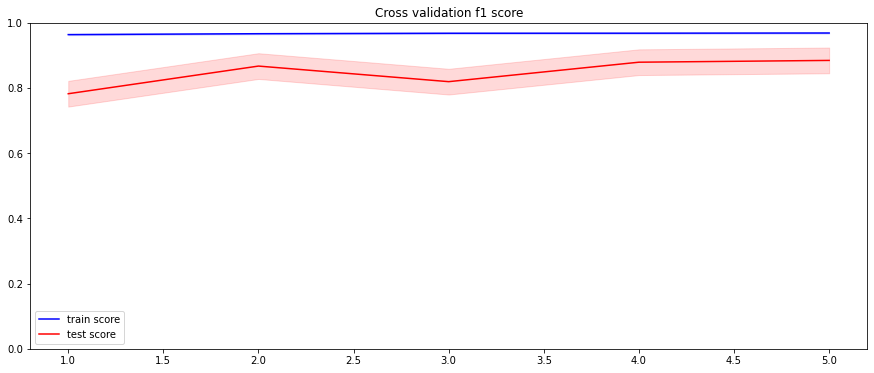

In [17]:
# Setting parameters for knn model and finding the best results

params = {'n_neighbors' : range (1, 20, 2), 
          'weights' : ['uniform', 'distance'], 
          'p' : range (1,5)}

knnmodel = KNeighborsClassifier (metric = 'minkowski', algorithm = 'brute')

knnmodel = classification (knnmodel, params)

##### Inferences :
    1. The KNN model gave a mean f1 score of 0.846 which is quite good.
    2. Though there seems to be over fitting but the variation in the test results are acceptable.
    3. The KNN model is good for predictions but we may want to try other models too.

### Support Vector Machine (SVM) model

The best parameters for SVC = {'kernel': 'linear', 'gamma': 1, 'degree': 3, 'C': 0.006158482110660267}
The best mean score = 0.6697
Mean train score = 0.7101977034942086, std = 0.048931377386881976
Mean test score = 0.6696782359910372, std = 0.0003318202156140093


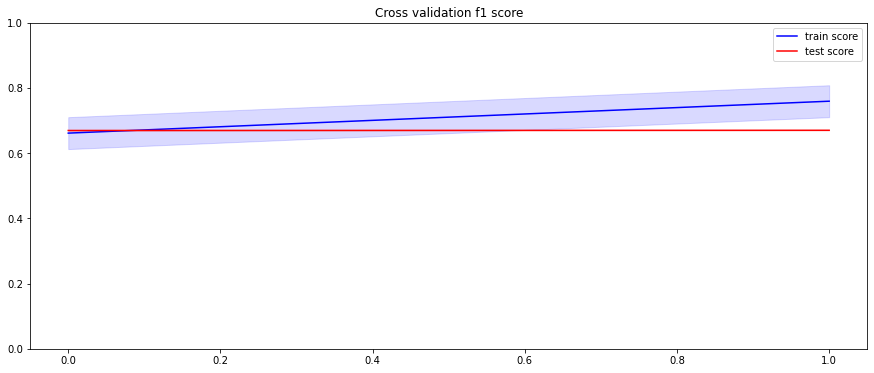

In [21]:
# Setting parameters for svc model and finding the best results

params = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], 
          'degree' : range (1,5), 
          'C' : np.logspace (-3, 2, 20), 
          'gamma' : [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]}

svcmodel = SVC ()

svcmodel = classification (svcmodel, params, cv = 2, n_iter = 10)

##### Inferences :
    1. The SVC model gave a mean f1 score of 0.67 which is quite poor.
    2. There is not much variation in the test results though.
    3. We cannot use SVC model for predictions.

### Random Forest model

The best parameters for RandomForestClassifier = {'max_features': 4, 'max_depth': 16}
The best mean score = 0.8557
Mean train score = 0.966846587043882, std = 0.0019771319798206777
Mean test score = 0.8557242751491849, std = 0.0478971736456233


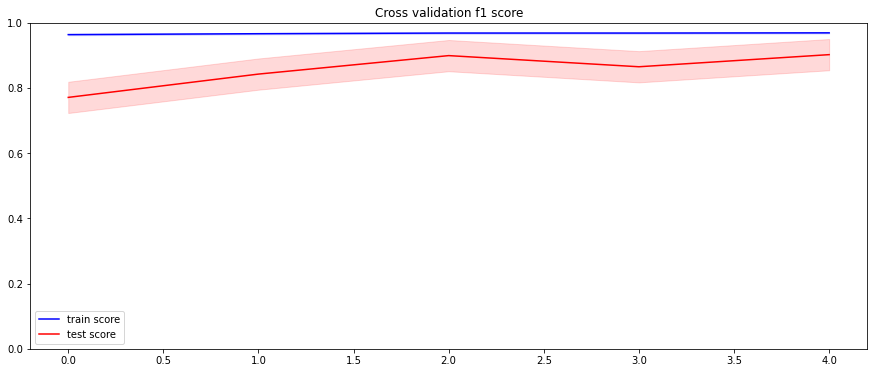

In [23]:
# Setting parameters for random forest model and finding the best results

params = {'max_depth' : range (1,50,5), 
          'max_features' : range (1,6)}

rfmodel = RandomForestClassifier (n_estimators = 50, class_weight = weights)

rfmodel = classification (rfmodel, params, cv = 5, n_iter = 20)

##### Inferences :
    1. The Random Forest model gave a mean f1 score of 0.86 which is quite good.
    2. Though there seems to be over fitting but the variation in the test results are acceptable.
    3. We can use Random Forest Model for predictions and can tune the no. of estimators for better results.

The best parameters for AdaBoostClassifier = {'n_estimators': 200, 'algorithm': 'SAMME.R'}
The best mean score = 0.7760
Mean train score = 0.8226810686752952, std = 0.015971469511750037
Mean test score = 0.7759763909880568, std = 0.06462730614180641


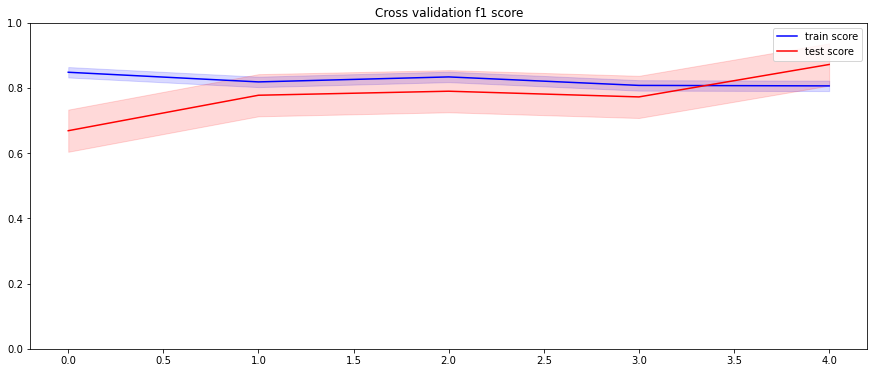

In [28]:
# Setting parameters for Ada boost model and finding the best results

params = {'n_estimators' : [20, 50, 75, 100, 150, 200], 
          'algorithm' : ['SAMME', 'SAMME.R']}

adamodel = AdaBoostClassifier (learning_rate = 0.01)

adamodel = classification (adamodel, params)

##### Inferences :
    1. The Adaboost model gave a mean f1 score of 0.776 which is less than that of Random Forest.
    2. There seems to be variation in the test results also.
    3. We may want to try XGboost model and see if it performs better than RF model.

The best parameters for XGBClassifier = {'min_child_weight': 2, 'max_depth': 4, 'lambda': 0.1, 'gamma': 0.2, 'alpha': 0.1}
The best mean score = 0.8268
Mean train score = 0.9661255965920083, std = 0.002037966490668895
Mean test score = 0.8267706850266905, std = 0.03985275219042955


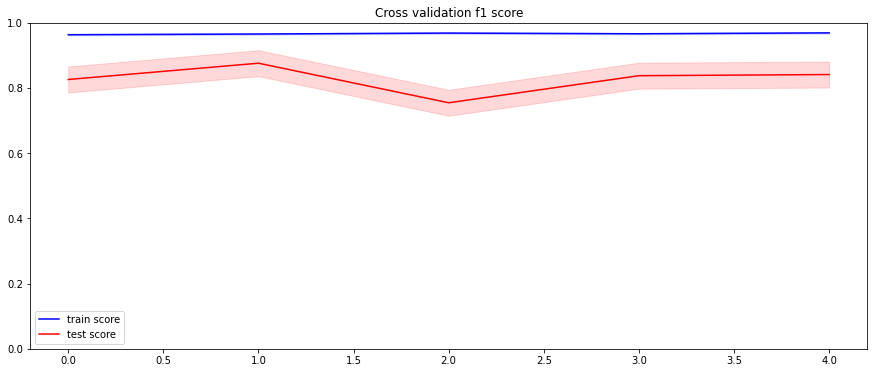

In [29]:
# Setting parameters for xgboost model and finding the best results

params = {'max_depth' : range (1,10), 
          'min_child_weight' : range (1,6), 
          'gamma' : [i/10.0 for i in range (0,5)], 
          'alpha' : [0.01, 0.1, 1, 5, 10], 
          'lambda' : [0.01, 0.1, 1, 5, 10]}

xgbmodel = XGBClassifier (objective = 'multi:softmax', n_estimators = 100, learning_rate = 0.1)

xgbmodel = classification (xgbmodel, params)

The best parameters for XGBClassifier = {'n_estimators': 950}
The best mean score = 0.8295
Mean train score = 0.9658566448843624, std = 0.0021297516793908917
Mean test score = 0.8295158746908167, std = 0.04542379375762591


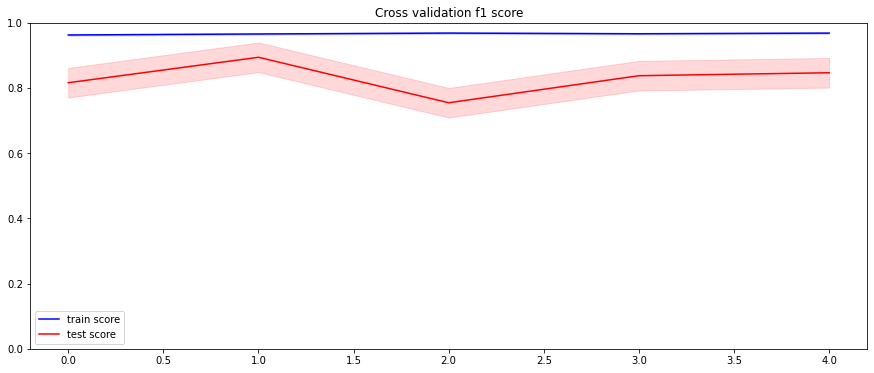

In [30]:
# Reducing the learning rate and finding the best number of estimators for xgboost model

xgbmodel.set_params (learning_rate = 0.01)

params = {'n_estimators' : range (50, 1000, 30)}

xgbmodel = classification (xgbmodel, params)

##### Inferences :
    1. The XGB model gave a mean f1 score of 0.8295 which is less than that of Random Forest.
    2. Though there seems to be over fitting but the variation in the test results are acceptable.
    3. The Random Forest Model performed better than XG boost model for this data set.

##### Prepared by: Sahaj Harnal
##### Email: sahajharnal@gmail.com